In [320]:
import pickle 
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import umap
import umap.plot
import matplotlib.pyplot as plt

from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)


import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets


def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    y_true_train: np.ndarray,
    y_true_test: np.ndarray,
    estimated_ate_test: np.ndarray,
    iss_test: np.ndarray
) -> None:
    
    xgb_model = xgb.XGBClassifier(  
        max_depth=5
    )
    
    xgb_model.fit(x_train[:, features], y_true_train)

    y_pred = xgb_model.predict(x_test[:, features])
    
    ate = np.sum(estimated_ate_test[y_pred == 1])/n

    auroc = metrics.roc_auc_score(y_true_test, y_pred)
    
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))
    
    # if iss_test.any():  
    print("%s - iss %s; %s "%(method , np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1))
    print("===================================")

def feature_idx(
    method: str,
    cohort: str
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_xlearner.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_xlearner.csv"
    elif method == "shap - 0 ":
        file_path = f"../results/{cohort}/shapley_value_sampling_top_5_features_xlearner.csv"
        
    df = pd.read_csv(file_path,keep_default_na=False)
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    print(df_sorted["feature"].head(5).tolist() )
    return [ x.columns.get_loc(col) for col in df_sorted["feature"].head(5) ]



## Responder cohort analysis

In [302]:
fluid_cohort = pd.read_pickle("../data/trauma_responder.pkl")


all_year = pd.read_csv("../data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                             x_train,  
                                             y_train, 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=x_train[:, treatment_index]
                                    )

w_train = x_train[:, treatment_index]
w_val = x_val[:, treatment_index]
w_test =  x_test[:, treatment_index]


iss_train = x_train[:, iss_index]
iss_test =  x_test[:, iss_index]

x_train = x_train[:,var_index]
x_val = x_val[:, var_index]
x_test = x_test[:, var_index]

x_learner = pseudo_outcome_nets.XLearner( 
    
    x_train.shape[1],
    binary_y=(len(np.unique(y_train)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1500,
    nonlin="relu",
    device="cuda:1",
)
dr_learner = pseudo_outcome_nets.DRLearner( 
    
    x_train.shape[1],
    binary_y=(len(np.unique(y_train)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1500,
    nonlin="relu",
    device="cuda:1",
)


x_learner.fit(x_train, y_train, w_train)
dr_learner.fit(x_train, y_train, w_train)

/tmp/ipykernel_40033/2438182252.py:4: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("../data/all_year.csv", index_col=0)


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6434566378593445, train_loss: 0.6783382296562195
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.5833740234375, train_loss: 0.35875338315963745
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5279456377029419, train_loss: 0.2741718888282776
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.49107691645622253, train_loss: 0.1359776109457016
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.4555080533027649, train_loss: 0.09119388461112976
[po_estimator_0_impute_pos] Epoch: 250, current validation loss: 0.4188792407512665, train_loss: 0.06903786957263947
[po_estimator_0_impute_pos] Epoch: 300, current validation loss: 0.39292556047439575, train_loss: 0.054843444377183914
[po_estimator_0_impute_pos] Epoch: 350, current validation loss: 0.3756180703639984, train_loss: 0.04403012990951538
[po_estimator_0_impute_pos] Epoch: 400, current validation loss: 0.357

DRLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=46, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=46, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimat

In [303]:
## Debug DR

def train_nuisance_models(
    x_val: np.ndarray,
    y_val: np.ndarray,
    w_val: np.ndarray
)-> tuple:

    mu0 = xgb.XGBClassifier()
    mu1 = xgb.XGBClassifier()
    m = xgb.XGBClassifier()
    rf = xgb.XGBClassifier(
        reg_lambda=2,
        max_depth=3,
        colsample_bytree=0.2,
        min_split_loss=10
    )

    x0, x1 = x_val[w_val == 0], x_val[w_val == 1]
    y0, y1 = y_val[w_val == 0], y_val[w_val == 1]

    mu0.fit(x0, y0)
    mu1.fit(x1, y1)
    m.fit(x_val, y_val)
    rf.fit(x_val, w_val)

    return mu0, mu1, rf, m

def calculate_if_pehe(
    w_test: np.ndarray,
    p: np.ndarray,
    prediction: np.ndarray,
    t_plugin: np.ndarray,
    y_test: np.ndarray,
    ident: np.ndarray
)-> np.ndarray:

    EPS = 1e-7
    a = w_test - p
    c = p * (ident - p)
    b = 2 * np.ones(len(w_test)) * w_test * (w_test - p) / (c + EPS)

    plug_in = (t_plugin - prediction) ** 2
    l_de = (ident - b) * t_plugin ** 2 + b * y_test * (t_plugin - prediction) + (- a * (t_plugin - prediction) ** 2 + prediction ** 2)

    return np.sum(plug_in) + np.sum(l_de)


def calculate_pseudo_outcome_pehe_dr(
    w_test: np.ndarray,
    p: np.ndarray,
    prediction: np.ndarray,
    y_test: np.ndarray,
    mu_1: np.ndarray,
    mu_0: np.ndarray
)-> np.ndarray:

    """
    calculating pseudo outcome for DR
    """
    # p = 0.5*np.ones(len(w_test))
    
    EPS = 1e-7
    w_1 = w_test / (p + EPS)
    w_0 = (1 - w_test) / (EPS + 1 - p)
    
    pseudo_outcome = (w_1 - w_0) * y_test + ((1 - w_1) * mu_1 - (1 - w_0) * mu_0)
        
    # pseudo_outcome = np.clip(pseudo_outcome, -1, 1)
    return np.sqrt(np.mean((prediction - pseudo_outcome) ** 2))



In [304]:
from sklearn.metrics import roc_auc_score

xgb_plugin0, xgb_plugin1, rf, m = train_nuisance_models(x_train, y_train, w_train)

mu_0 = xgb_plugin0.predict_proba(x_test)[:, 1]
mu_1 = xgb_plugin1.predict_proba(x_test)[:, 1]

mu = m.predict_proba(x_test)[:, 1]
p = rf.predict_proba(x_test)[:, 1]

print("AUROC for propensity model", roc_auc_score(w_test, p))

t_plugin = mu_1 - mu_0
ident = np.ones(len(p))

x_prediction = x_learner.predict(X=x_test).detach().cpu().numpy().flatten()
dr_prediction = dr_learner.predict(X=x_test).detach().cpu().numpy().flatten()

print(np.mean(x_prediction), np.mean(dr_prediction))

print("pehe_dr: xlearner", calculate_pseudo_outcome_pehe_dr(w_test, p, x_prediction, y_test, mu_1, mu_0))
print("pehe_dr: drlearner", calculate_pseudo_outcome_pehe_dr(w_test, p, dr_prediction, y_test, mu_1, mu_0))

AUROC for propensity model 0.5
0.019449778 0.29920733
pehe_dr: xlearner 1.7713610607056494
pehe_dr: drlearner 1.7435651065139144


In [321]:
results_train = pickle.load(open("../results/responder/train_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/responder/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)
threshold = np.mean(estimated_ate_train)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")
lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")

explainers = {
    "shap": feature_idx("shap","responder"),
    "shap - 0 ": feature_idx("shap - 0 ","responder" ), #[temp, ph, bd, hgb, pulse ]
    "ig": feature_idx("ig","responder" ), #[ph, na, temp, gender, fio2 ],
    
    "clinical": [lac, inr, hgb,scenefirstbloodpressure ],
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}


print("mean ISS: ", np.mean(iss_test)*74+1)
print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)
print("===================================")

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        iss_test
    )

0.21012758868640846 0.022916098208791365
0.2053813276515269 0.04399229782697588
['traumatype_B', 'causecode_CUT', 'sex_M', 'edgcs', 'causecode_GUN']
['PH', 'HCT', 'temps2', 'scenegcs', 'traumatype_B']
['temps2', 'HCT', 'PH', 'traumatype_B', 'NA']
mean ISS:  29.70394736842105
original 0.03809869510749887
original - iss 29.774647887323944 28.699999999999996
shap - auroc 0.4797402597402597
shap - ATE 0.01854604204211075
shap - iss 27.14285714285715; 31.890243902439025 
shap - 0  - auroc 0.5272727272727273
shap - 0  - ATE 0.024508233179862216
shap - 0  - iss 29.89655172413794; 29.446153846153845 
ig - auroc 0.5787012987012987
ig - ATE 0.022168964689857615
ig - iss 29.835616438356162; 29.582278481012654 
clinical - auroc 0.5522077922077921
clinical - ATE 0.022064024341085304
clinical - iss 29.422535211267608; 29.950617283950614 
full features - auroc 0.5067532467532467
full features - ATE 0.02080623888317373
full features - iss 29.961538461538467; 29.432432432432435 
random features - auroc

## Transfusion 

In [322]:
fluid_cohort = pd.read_pickle("../data/low_bp_survival.pkl")

all_year = pd.read_csv("../data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                    "COV",
                                                    "TT",
                                                    "scenegcsmotor",
                                                    "scenegcseye",
                                                    "scenegcsverbal",
                                                    "edgcsmotor",
                                                    "edgcseye",
                                                    "edgcsverbal",
                                                    "outcome",
                                                    "sex_F",
                                                    "traumatype_P",
                                                    "traumatype_other",
                                                ])
                    ]

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                             x_train,  
                                             y_train, 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=x_train[:, treatment_index]
                                    )


w_train = x_train[:, treatment_index]
w_val = x_val[:, treatment_index]
w_test =  x_test[:, treatment_index]

iss_train = x_train[:, iss_index]
iss_test =  x_test[:, iss_index]

x_train = x_train[:,var_index]
x_val = x_val[:, var_index]
x_test = x_test[:, var_index]

x_learner = pseudo_outcome_nets.XLearner( 
    
    x_train.shape[1],
    binary_y=(len(np.unique(y_train)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1500,
    nonlin="relu",
    device="cuda:1",
)
dr_learner = pseudo_outcome_nets.DRLearner( 
    
    x_train.shape[1],
    binary_y=(len(np.unique(y_train)) == 2),
    n_layers_out=2,
    n_units_out=100,
    batch_size=128,
    n_iter=1500,
    nonlin="relu",
    device="cuda:1",
)


x_learner.fit(x_train, y_train, w_train)
dr_learner.fit(x_train, y_train, w_train)

/tmp/ipykernel_40033/4013390563.py:3: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("../data/all_year.csv", index_col=0)


[po_estimator_0_impute_pos] Epoch: 0, current validation loss: 0.6739606857299805, train_loss: 0.6328368186950684
[po_estimator_0_impute_pos] Epoch: 50, current validation loss: 0.56540447473526, train_loss: 0.4371078312397003
[po_estimator_0_impute_pos] Epoch: 100, current validation loss: 0.5294803977012634, train_loss: 0.3286193907260895
[po_estimator_0_impute_pos] Epoch: 150, current validation loss: 0.5187534689903259, train_loss: 0.2616085410118103
[po_estimator_0_impute_pos] Epoch: 200, current validation loss: 0.5173234343528748, train_loss: 0.21626016497612
[po_estimator_1_impute_pos] Epoch: 0, current validation loss: 0.7102606296539307, train_loss: 0.7698997855186462
[po_estimator_1_impute_pos] Epoch: 50, current validation loss: 0.6301138401031494, train_loss: 0.5559946894645691
[po_estimator_1_impute_pos] Epoch: 100, current validation loss: 0.588813841342926, train_loss: 0.43144458532333374
[po_estimator_1_impute_pos] Epoch: 150, current validation loss: 0.577546894550323

DRLearner(
  (_te_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=51, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
    )
  )
  (_po_estimator): BasicNet(
    (model): Sequential(
      (0): Linear(in_features=51, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=100, out_features=1, bias=True)
      (7): Sigmoid()
    )
  )
  (_propensity_estimat

In [301]:
xgb_plugin0, xgb_plugin1, rf, m = train_nuisance_models(x_train, y_train, w_train)

mu_0 = xgb_plugin0.predict_proba(x_test)[:, 1]
mu_1 = xgb_plugin1.predict_proba(x_test)[:, 1]

mu = m.predict_proba(x_test)[:, 1]
p = rf.predict_proba(x_test)[:, 1]

print("AUROC for propensity model", roc_auc_score(w_test, p))

t_plugin = mu_1 - mu_0
ident = np.ones(len(p))

x_prediction = x_learner.predict(X=x_test).detach().cpu().numpy().flatten()
dr_prediction = dr_learner.predict(X=x_test).detach().cpu().numpy().flatten()

print(calculate_pseudo_outcome_pehe_dr(w_test, p, x_prediction, y_test, mu_1, mu_0))
print(calculate_pseudo_outcome_pehe_dr(w_test, p, dr_prediction, y_test, mu_1, mu_0))

AUROC for propensity model 0.8305577849117175
0.8321216786995042
0.9044934055773273


In [326]:
results_train = pickle.load(open("../results/massive_trans/train_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/massive_trans/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)
threshold = np.mean(estimated_ate_train)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")
lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")

explainers = {
    "shap": feature_idx("shap","responder"), #[gender,trauma ,cause_cut, edgcs, cause_mv ]
    "shap - 0 ": feature_idx("shap - 0 ","responder" ), #[temp, ph, bd, hgb, trauma ]
    "ig": feature_idx("ig","responder" ), #[ph, na, temp, gender, trauma ],
    
    "clinical": [lac, inr, hgb,scenefirstbloodpressure ],
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}

print("mean ISS: ", np.mean(iss_test)*74+1)
print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)
print("===================================")

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        iss_test
    )

-0.055822201781090916 0.01128492608250522
-0.047783710723696506 0.021390057599922293
['traumatype_B', 'causecode_CUT', 'sex_M', 'edgcs', 'causecode_GUN']
['PH', 'HCT', 'temps2', 'scenegcs', 'traumatype_B']
['temps2', 'HCT', 'PH', 'traumatype_B', 'NA']
mean ISS:  29.641791044776117
original -0.007331925282529388
original - iss 33.169642857142854 25.202247191011242
shap - auroc 0.5117559523809524
shap - ATE -0.0019779173414263707
shap - iss 30.457627118644066; 29.30281690140845 
shap - 0  - auroc 0.5209821428571428
shap - 0  - ATE -0.0034720158256382576
shap - 0  - iss 30.16822429906542; 29.04255319148936 
ig - auroc 0.5019345238095239
ig - ATE -0.0044988380711659245
ig - iss 32.14563106796117; 27.010204081632654 
clinical - auroc 0.4758928571428571
clinical - ATE -0.0047931352598718805
clinical - iss 30.703703703703702; 28.40860215053764 
full features - auroc 0.4903273809523809
full features - ATE -0.0037122418315509755
full features - iss 29.284090909090907; 29.920353982300888 
random

In [139]:
ist3 = pd.read_sas("../data/datashare_aug2015.sas7bdat")

continuous_vars = [
                    "gender",
                    "age",
                    "weight",
                    "glucose",
                    "gcs_eye_rand",
                    "gcs_motor_rand",
                    "gcs_verbal_rand",
                    # "gcs_score_rand",   
                     "nihss" ,
                     "sbprand",
                     "dbprand",
                  ]

cate_variables = [
                     # "livealone_rand",
                     # "indepinadl_rand",
                     "infarct",
                     "antiplat_rand",
                     # "atrialfib_rand",
                    #  "liftarms_rand",
                    # "ablewalk_rand",
                    # "weakface_rand",
                    # "weakarm_rand",
                    # "weakleg_rand",
                    # "dysphasia_rand",
                    # "hemianopia_rand",
                    # "visuospat_rand",
                    # "brainstemsigns_rand",
                    # "otherdeficit_rand",
                    "stroketype"
                 ]

outcomes = ["dead7","dead6mo","aliveind6"]
treatment = ["itt_treat"]

x = ist3[continuous_vars + cate_variables + treatment]

x = pd.get_dummies(x, columns=cate_variables)

n, feature_size = x.shape


names = x.drop(["itt_treat"], axis=1).columns
treatment_index = x.columns.get_loc("itt_treat")
var_index = [i for i in range(feature_size) if i != treatment_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             ist3["aliveind6"], 
                                             test_size=0.2, 
                                             random_state=20,
                                    )

x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                            x_train,
                                            y_train,
                                            test_size=0.2,
                                            random_state=50,
                                    )


w_train = x_train[:, treatment_index] == 0
w_test =  x_test[:, treatment_index] == 0

x_train = x_train[:,var_index]
x_test = x_test[:, var_index]

y_train = y_train ==0
y_test = y_test ==0

In [140]:
results_train = pickle.load(open("../results/ist3/train_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/ist3/test_xlearner.pkl", "rb"))

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)
threshold = np.mean(estimated_ate_train)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

# scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")
# lac  = x.columns.get_loc("LAC")
# inr  = x.columns.get_loc("INR")
# hgb  = x.columns.get_loc("HGB")

explainers = {
    "shap": feature_idx("shap","ist3"), #[gender,trauma ,cause_cut, edgcs, cause_mv ]
    "shap - 0 ": feature_idx("shap - 0","ist3" ), #[temp, ph, bd, hgb, trauma ]
    "ig": feature_idx("ig","ist3" ), #[ph, na, temp, gender, trauma ],
    
    # "clinical": [lac, inr, hgb,scenefirstbloodpressure ],
    "full features": [ i for i in range(x_train.shape[1])],
    "random features": np.random.randint(x_train.shape[1], size=(5)),
}

for explainer, features in explainers.items():
    subgroup_ate(
        explainer,
        features,
        y_true_train,
        y_true_test,
        estimated_ate_test,
        None
    )

0.0014999985861160743 0.0019497298885327702
0.0012145126779307496 0.003587692772870593
['antiplat_rand_2.0', 'infarct_0.0', 'stroketype_2.0', 'stroketype_1.0', 'infarct_2.0']
['gcs_eye_rand', 'nihss', 'gcs_motor_rand', 'glucose', 'stroketype_2.0']
['gcs_eye_rand', 'gcs_motor_rand', 'age', 'stroketype_1.0', 'gcs_verbal_rand']
shap - auroc 0.5198528292863198
shap - ATE 4.7815562819653894e-05
shap - 0  - auroc 0.46081606921588664
shap - 0  - ATE -2.1063881854126236e-05
ig - auroc 0.4662724723375579
ig - ATE -0.0001588486487205452
full features - auroc 0.4940273037542662
full features - ATE 0.0001482719506322724
random features - auroc 0.4747994608812852
random features - ATE -3.9418327892153094e-05


(array([ 6., 15., 13., 17.,  8., 15.,  8.,  3.,  1.,  2.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

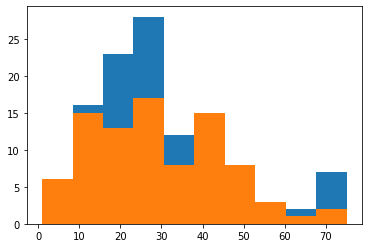

In [9]:
import matplotlib.pyplot as plt 

plt.hist(iss_test[y_pred==1]*74+1)
plt.hist(iss_test[y_pred==0]*74+1)